[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Groaaaar/SimpleClassifier/blob/main/Ambiance-Product-Schema-Colab.ipynb)


In [2]:
!wget https://github.com/Groaaaar/SimpleClassifier/blob/main/data.zip

import zipfile
zip_ref = zipfile.ZipFile("data.zip", "r")
zip_ref.extractall()
zip_ref.close()

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [50]:
import matplotlib.pyplot as plt # must - visualisation
import seaborn as sns           # optionnel
import numpy as np              # must
import pandas as pd             # must - excel
import os                       # light
import random                   # light
from PIL import Image           # traitement d'image

In [51]:
root_dir = "./CARREFOUR/"
labels = os.listdir(root_dir)
labels

['_AMBIANCE', '_PRODUCT', '_SKETCH']

# Define a few functions to load and transform pictures
* `load_pic` : load picture as numpy array in 3D (X,Y,Color)
* `normalize pic` : normalize the colors. Round all RGB code to 0.1 (RGB normalized to [0,1]
* `conv` : transformation to compute a metric showing the variation between a pixel and its neighbours
* `pixelise` : pixelise a picture in 5x5 pixel bloacks
* `crop` : take the external  pixels around the image
* `visualize_sample` : pick a random sample belonging to a label and compare it with the transformed pictures

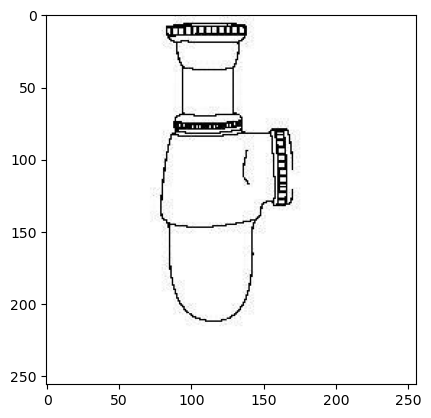

In [179]:
def load_pic(*args):
    """
    Load a picture, resolve conversion issues, normalize it [0,1]. Takes the path as input and return a numpy array
    """
    pic = Image.open(os.path.join(*args))
    array = np.array(pic)
    if array.ndim==2:
        array = np.stack([array,array,array],axis=2)
    return array/255.0
    
        
plt.imshow(load_pic(root_dir,labels[2],'s00173_PIM.PNG'));

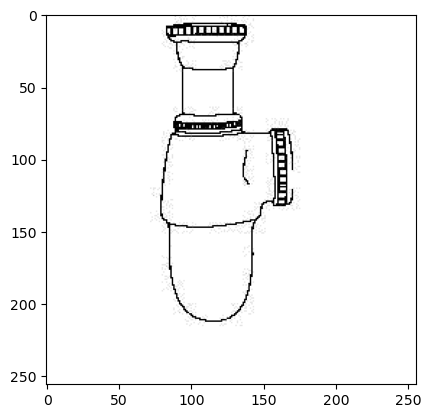

In [53]:
def normalize_pic(pic):
    """
    normalize the colors to avoid dust effect. Rounds to nearest 0.1.
    """
    pic = np.round(pic*10,decimals=0)/10
    return pic

plt.imshow(normalize_pic(load_pic(root_dir,labels[2],'s00173_PIM.PNG')));


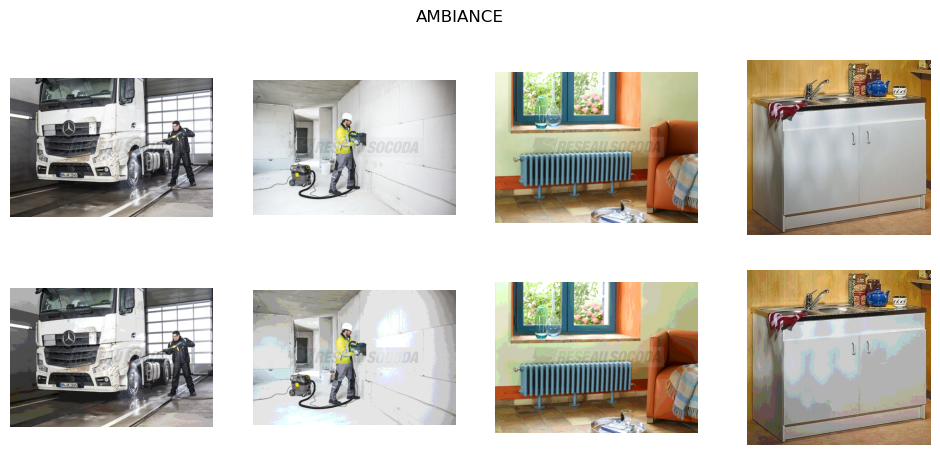

In [170]:
def visualize_sample(l, func=None):
    """
    Visualize 8 pictures. If no transformation function is chosen, choose 8 random picture from the choosen label.
    If a transformation is chosen then choose 4 pictures and display the pictures and the transformed pictures
    """
    plt.figure(figsize=(12,5))
    plt.suptitle(l[1:])
    vis_dir =  os.path.join(root_dir,l)
    pics = os.listdir(vis_dir)
    if func:
        pics = random.sample(pics,4)
        for i,f in enumerate(pics):
            im = load_pic(vis_dir,f)
            for j in range(2):
                plt.subplot(2,4,i+1+4*j)
                plt.gca().axis('off')
                plt.imshow(im)
                im=func(im)
    else:
        pics = random.sample(pics,8)
        for i,f in enumerate(pics):    
            plt.subplot(2,4,i+1)
            im = load_pic(vis_dir,f)
            plt.gca().axis('off')
            plt.imshow(im)
    
visualize_sample(labels[0],normalize_pic)


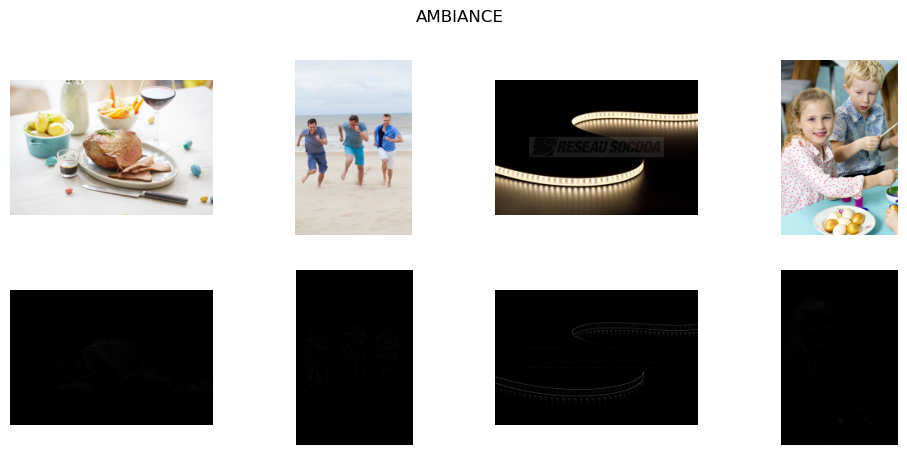

In [171]:
def conv(pic):
    """
    expect pic to be normalized (0,1)
    """
    my_array = np.array(pic,dtype=float)
    my_array = my_array[1:-1,1:-1] - 0.25*(my_array[1:-1,2:]+my_array[1:-1,:-2]+
                                          my_array[2:,1:-1]+my_array[:-2,1:-1])
    my_array[my_array<0] = 0
    return my_array 
visualize_sample(labels[0],conv)

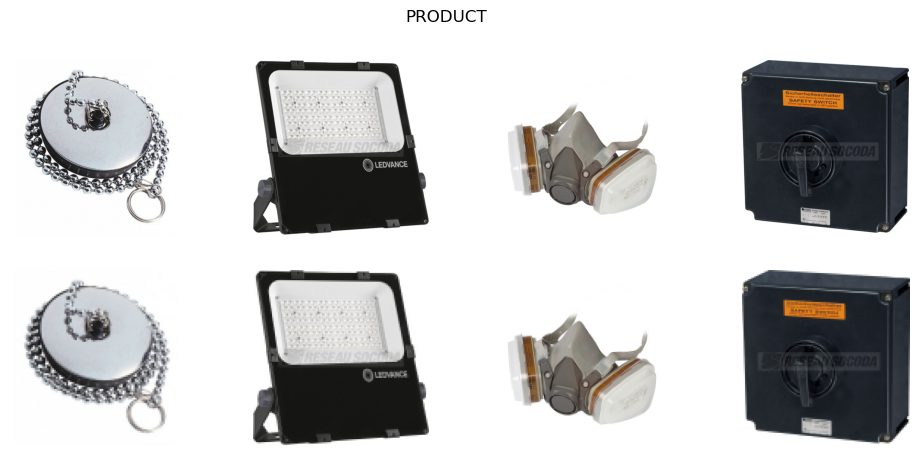

In [172]:
def pixelise_pic(pic):
    dim = np.array(pic.shape)
    dim = 5 * (dim//5)
    blocked_matrix = np.reshape(pic[0:dim[0],0:dim[1]], (dim[0]//5, 5, dim[1]//5, 5,3)).mean(axis=(1,3))
    return blocked_matrix
visualize_sample(labels[1],pixelise_pic)

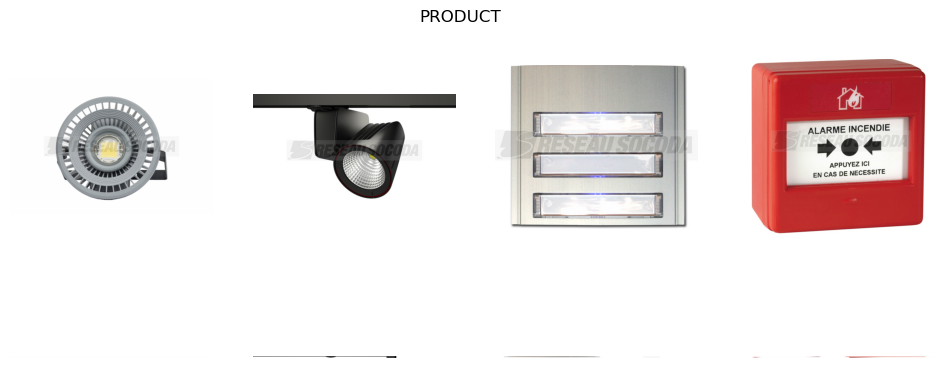

In [57]:
def crop(pic):
    hor = np.vstack((pic[:5,:,:],pic[-5:,:,:]))
    ver = np.vstack((pic[:,:5,:].transpose([1,0,2]),pic[:,-5:,:].transpose([1,0,2])))
    return np.hstack((hor,ver))
visualize_sample(labels[1],crop)

# Stats 
## Get statistics from images
We will gather statistics from pictures : 
- mean value across pixels (darkness)
- standard deviation across pixels
- how many different colors are there in the picture ?

We first take a random image from each label

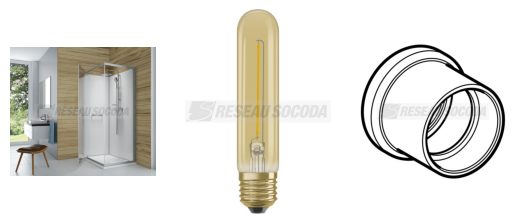

In [58]:
test=[None for i in range(len(labels))]
for i in range(len(labels)):
    pic = random.choice(os.listdir(os.path.join(root_dir,labels[i])))
    test[i] = load_pic(root_dir,labels[i],pic)
    plt.subplot(1,3,i+1)
    plt.gca().axis('off')
    plt.imshow(test[i])


We then count the amount of colors and display it for each picture

In [59]:
def get_colors(pic):
    """
    Return the different colors in a picture
    """
    dim = pic.shape
    return np.unique(np.resize(pic,(dim[0]*dim[1],3)),axis=0)

def visualise_colors(pic):
    """
    Visualise all colors in a pic
    """
    pic = get_colors(pic)
    pic = np.resize(pic,(pic.shape[0]//50+1,pic.shape[0],3))
    plt.imshow(pic)
    plt.gca().axis('off')
    plt.show()
    
def get_q_colors(pic):
    """
    Return the quantity of different colors in a picture
    """
    dim = pic.shape
    return len(np.unique(np.resize(pic,(dim[0]*dim[1],3)),axis=0))
for i in test:
    print (get_q_colors(i), "Different colors")
    visualise_colors(i)

59301 Different colors


17205 Different colors


256 Different colors


We do the same with the normalized pictures

174


89


11


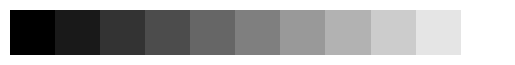

In [60]:
for i in test:
    print (get_q_colors(normalize_pic(i)))
    visualise_colors(normalize_pic(i))

In [61]:
for i in test:
    print (get_q_colors(conv(i)))
    visualise_colors(conv(i))

76279


14092


887


In [62]:
for i in test:
    print (get_q_colors(pixelise_pic(i)))
    visualise_colors(pixelise_pic(i))

12513


3005


3020


Let's build our features:
* mean
* standard deviation
* amount of different color   
for the picture, the normalized picture, the pixelized picture and the the pixelised convolution

In [63]:
def get_stats(pic):
    output = []
    output.append(pic.mean())
    output.append(pic.std())
    output.append(get_q_colors(pic))
    return output

In [64]:
X = []
for i in range(len(labels)):
    files = os.listdir(os.path.join(root_dir,labels[i]))
    for f in files:
        pic = load_pic(root_dir,labels[i],f)
        row = get_stats(pic)
        row = row + get_stats(normalize_pic(pic))
        row = row + get_stats(pixelise_pic(pic))
        row = row + get_stats(pixelise_pic(conv(pic)))
        row = row + get_stats(pixelise_pic(crop(pic)))
        row = row + [pic.shape[0]*pic.shape[1]]
        row = [labels[i][1:],os.path.join(root_dir,labels[i],f)] + row
        X.append(row)

In [65]:
data = pd.DataFrame(data=X,columns=["name","path","mean","std","q_col",
                                   "norm_mean","norm_std","norm_q_col",
                                    "pix_mean","pix_std","pix_q_col",
                                    "conv_mean","conv_std","conv_q_col",
                                    "crop_mean","crop_std","crop_q_col",
                                    "q_pixel"
                                   ])

In [66]:
data

,name,path,mean,std,q_col,norm_mean,norm_std,norm_q_col,pix_mean,pix_std,pix_q_col,conv_mean,conv_std,conv_q_col,crop_mean,crop_std,crop_q_col,q_pixel
0,AMBIANCE,./CARREFOUR/_AMBIANCE\21aafd2a-c440-4821-8f99-...,0.783510,0.184926,29343,0.782818,0.186801,229,0.783510,0.175791,9301,0.005508,0.008581,9057,0.734328,0.168235,394,240000
1,AMBIANCE,./CARREFOUR/_AMBIANCE\5J2A0025.jpg,0.378833,0.242744,69016,0.378897,0.244625,160,0.378224,0.237763,15433,0.004020,0.005465,15224,0.459044,0.259696,509,392448
2,AMBIANCE,./CARREFOUR/_AMBIANCE\5J2A4572.jpg,0.626952,0.249731,258647,0.626203,0.250621,683,0.627158,0.246317,64550,0.003201,0.005235,60365,0.607353,0.264198,996,1707200
3,AMBIANCE,./CARREFOUR/_AMBIANCE\7dc36e90-8a98-442e-91f6-...,0.422271,0.192256,22738,0.422472,0.195010,128,0.422271,0.182203,8455,0.012711,0.008150,8563,0.520437,0.223622,375,220900
4,AMBIANCE,./CARREFOUR/_AMBIANCE\AB_SIMPLY YOU_ 042.jpg,0.672570,0.270115,117306,0.673572,0.272723,447,0.672752,0.264653,23690,0.004722,0.005940,23693,0.722484,0.199585,585,698368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,SKETCH,./CARREFOUR/_SKETCH\s00173_PIM.PNG,0.971795,0.158435,79,0.972119,0.159804,6,0.971573,0.103886,327,0.010970,0.033146,437,0.998980,0.004592,11,65536
78,SKETCH,./CARREFOUR/_SKETCH\s00642_2_PIM.PNG,0.954854,0.171855,592,0.955897,0.172625,35,0.954600,0.132517,2194,0.006089,0.014578,2797,0.999387,0.002711,25,503384
79,SKETCH,./CARREFOUR/_SKETCH\s00649_2_PIM.PNG,0.949720,0.186882,699,0.950593,0.188213,32,0.949720,0.137010,1271,0.009398,0.019700,1674,0.999529,0.001402,28,202500
80,SKETCH,./CARREFOUR/_SKETCH\s00649_2_THB.PNG,0.948538,0.153708,337,0.949933,0.155659,18,0.948538,0.108429,496,0.011713,0.017418,621,0.953075,0.096903,36,40000


In [67]:
base = ['name',"q_pixel"]
std_col = ["mean","std","q_col"]
norm_col = [i for i in data.columns if "norm" in i]
pix_col =  [i for i in data.columns if "pix" in i]
pix_col.remove("q_pixel")
conv_col =  [i for i in data.columns if "conv" in i]
crop_col =  [i for i in data.columns if "crop" in i]


In [68]:
data.name.value_counts()

PRODUCT     56
AMBIANCE    16
SKETCH      10
Name: name, dtype: int64

In [69]:
data.columns

Index(['name', 'path', 'mean', 'std', 'q_col', 'norm_mean', 'norm_std',
       'norm_q_col', 'pix_mean', 'pix_std', 'pix_q_col', 'conv_mean',
       'conv_std', 'conv_q_col', 'crop_mean', 'crop_std', 'crop_q_col',
       'q_pixel'],
      dtype='object')

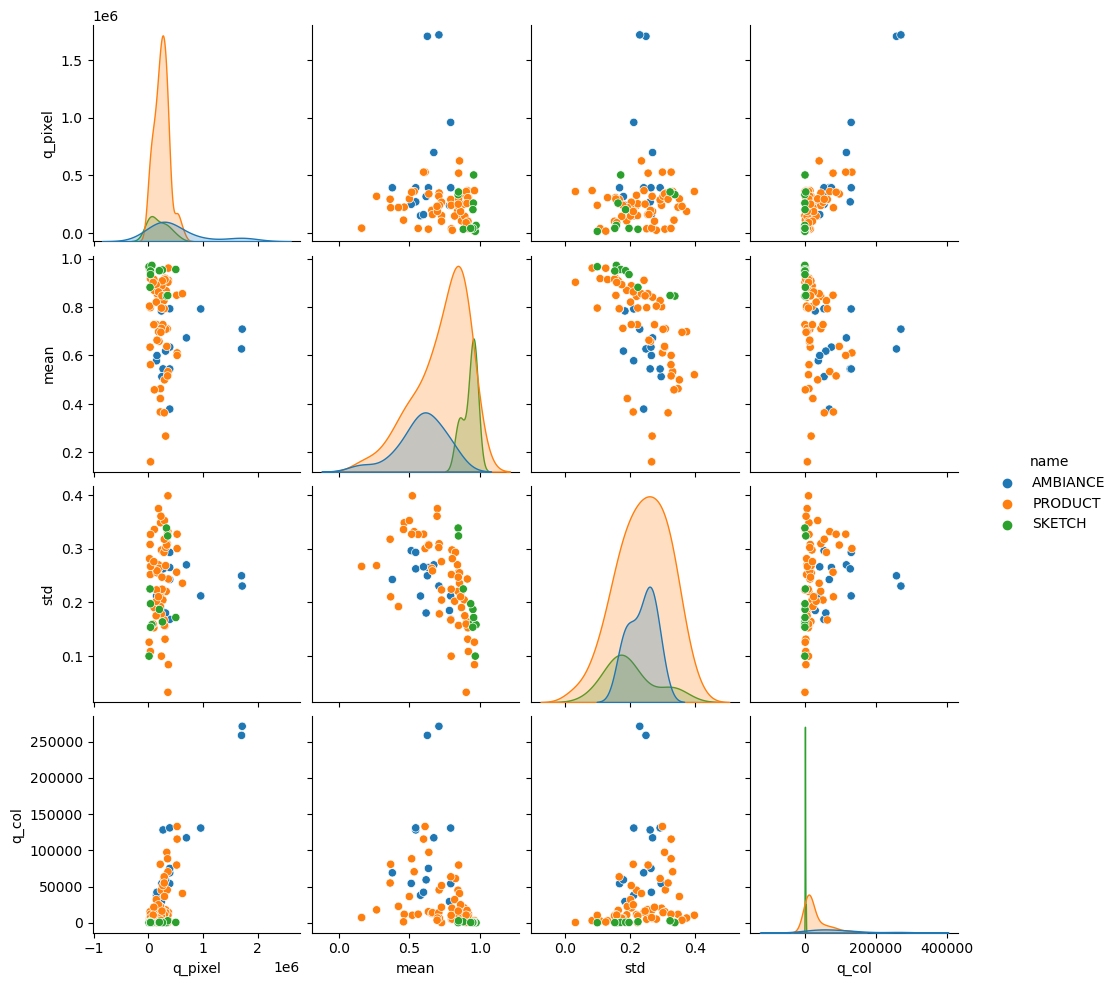

In [100]:
sns.pairplot(data[base+std_col],hue="name");


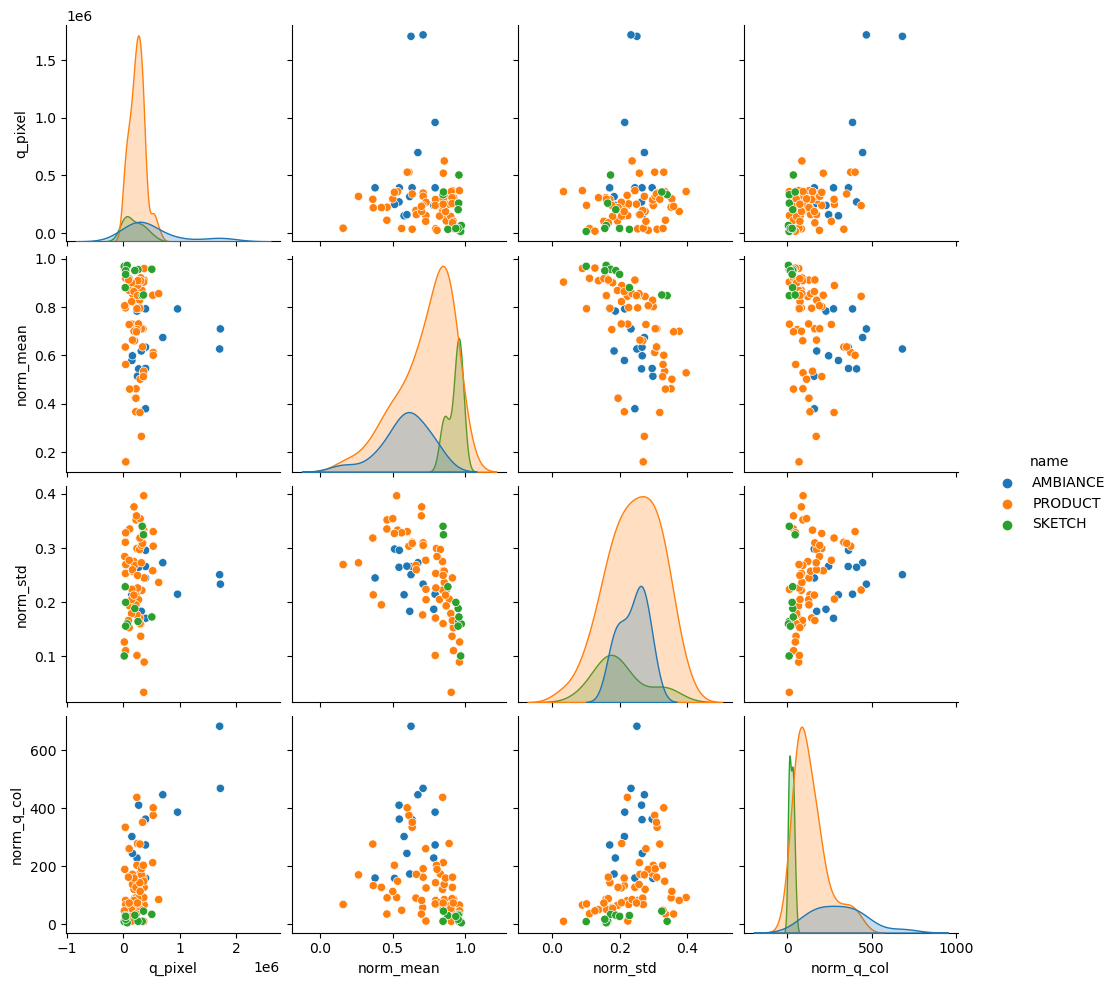

In [86]:
sns.pairplot(data[base+norm_col],hue="name");

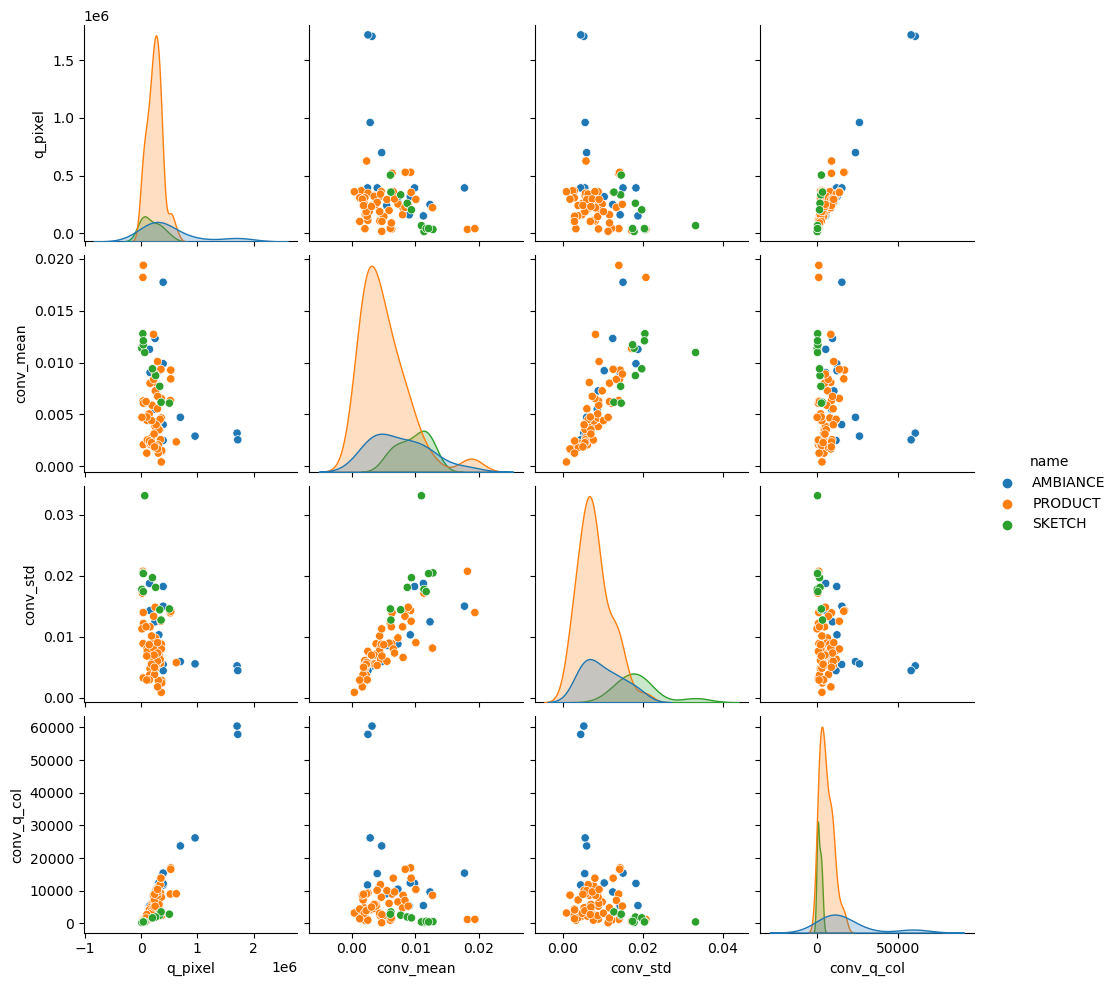

In [87]:
sns.pairplot(data[base+conv_col],hue='name');

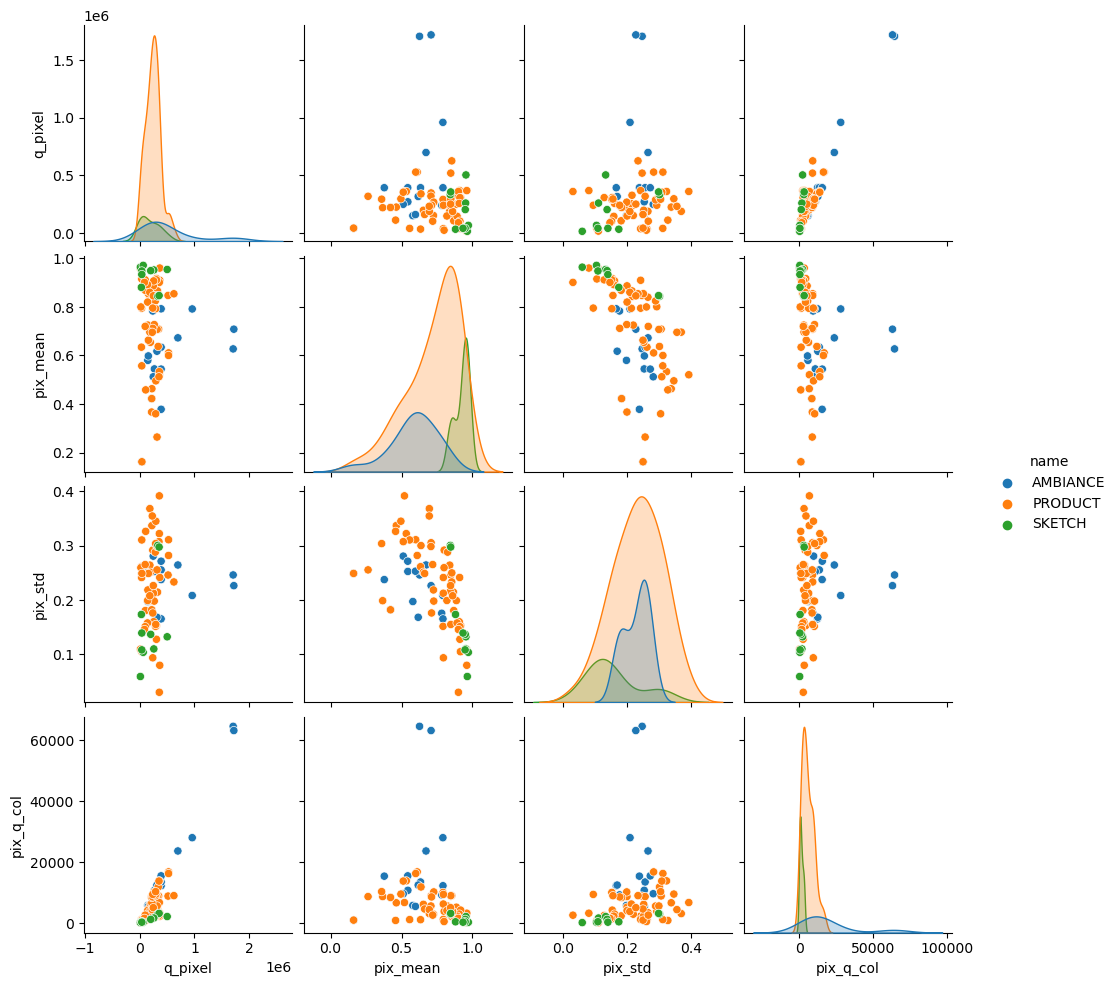

In [23]:
sns.pairplot(data[base+pix_col],hue="name");

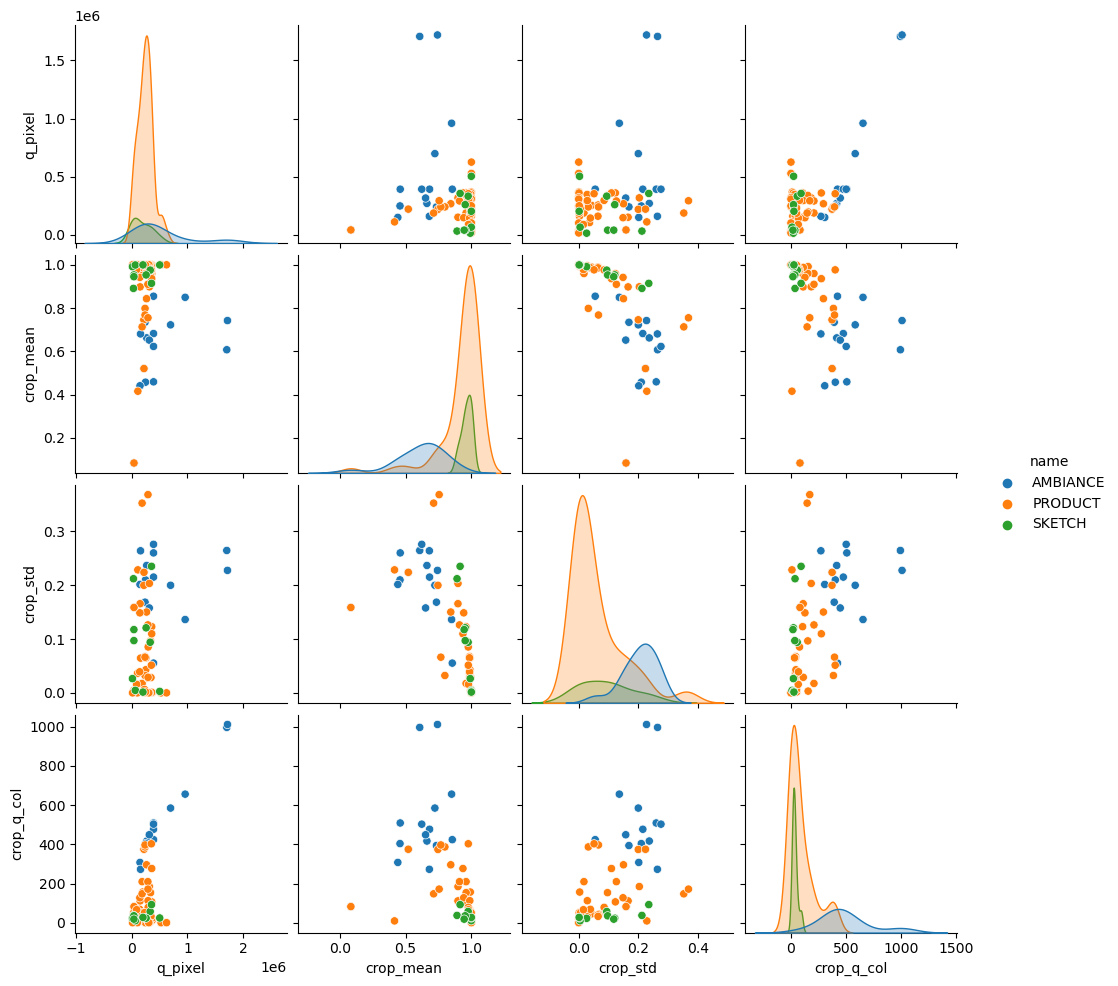

In [88]:
sns.pairplot(data[base+crop_col],hue="name");

In [101]:
data.join(pd.get_dummies(data['name'])).corr()[['AMBIANCE','PRODUCT','SKETCH']]


,AMBIANCE,PRODUCT,SKETCH
mean,-0.347122,0.020817,0.390783
std,0.011124,0.110185,-0.170160
q_col,0.544169,-0.277368,-0.264590
norm_mean,-0.347997,0.021757,0.390505
norm_std,0.011819,0.111833,-0.173345
norm_q_col,0.544027,-0.202387,-0.371045
pix_mean,-0.345298,0.018894,0.391308
pix_std,0.037247,0.195336,-0.322886
pix_q_col,0.522894,-0.284256,-0.229030
conv_mean,0.163620,-0.363054,0.318127


In [102]:
data

,name,path,mean,std,q_col,norm_mean,norm_std,norm_q_col,pix_mean,pix_std,pix_q_col,conv_mean,conv_std,conv_q_col,crop_mean,crop_std,crop_q_col,q_pixel
0,AMBIANCE,./CARREFOUR/_AMBIANCE\21aafd2a-c440-4821-8f99-...,0.783510,0.184926,29343,0.782818,0.186801,229,0.783510,0.175791,9301,0.005508,0.008581,9057,0.734328,0.168235,394,240000
1,AMBIANCE,./CARREFOUR/_AMBIANCE\5J2A0025.jpg,0.378833,0.242744,69016,0.378897,0.244625,160,0.378224,0.237763,15433,0.004020,0.005465,15224,0.459044,0.259696,509,392448
2,AMBIANCE,./CARREFOUR/_AMBIANCE\5J2A4572.jpg,0.626952,0.249731,258647,0.626203,0.250621,683,0.627158,0.246317,64550,0.003201,0.005235,60365,0.607353,0.264198,996,1707200
3,AMBIANCE,./CARREFOUR/_AMBIANCE\7dc36e90-8a98-442e-91f6-...,0.422271,0.192256,22738,0.422472,0.195010,128,0.422271,0.182203,8455,0.012711,0.008150,8563,0.520437,0.223622,375,220900
4,AMBIANCE,./CARREFOUR/_AMBIANCE\AB_SIMPLY YOU_ 042.jpg,0.672570,0.270115,117306,0.673572,0.272723,447,0.672752,0.264653,23690,0.004722,0.005940,23693,0.722484,0.199585,585,698368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,SKETCH,./CARREFOUR/_SKETCH\s00173_PIM.PNG,0.971795,0.158435,79,0.972119,0.159804,6,0.971573,0.103886,327,0.010970,0.033146,437,0.998980,0.004592,11,65536
78,SKETCH,./CARREFOUR/_SKETCH\s00642_2_PIM.PNG,0.954854,0.171855,592,0.955897,0.172625,35,0.954600,0.132517,2194,0.006089,0.014578,2797,0.999387,0.002711,25,503384
79,SKETCH,./CARREFOUR/_SKETCH\s00649_2_PIM.PNG,0.949720,0.186882,699,0.950593,0.188213,32,0.949720,0.137010,1271,0.009398,0.019700,1674,0.999529,0.001402,28,202500
80,SKETCH,./CARREFOUR/_SKETCH\s00649_2_THB.PNG,0.948538,0.153708,337,0.949933,0.155659,18,0.948538,0.108429,496,0.011713,0.017418,621,0.953075,0.096903,36,40000


# Model with sklearn

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [104]:
y = data['name']
X = data.iloc[:,2:]

In [105]:
steps = [('scaler', StandardScaler()),
         ('svm', SVC(kernel='linear', C=10, probability=True))]
classifier = Pipeline(steps)
classifier.fit(X,y)
preds = classifier.predict(X)
probs = classifier.predict_proba(X)

In [113]:
print(preds)
np.argmax(probs,axis=1)

['AMBIANCE' 'AMBIANCE' 'AMBIANCE' 'AMBIANCE' 'AMBIANCE' 'AMBIANCE'
 'AMBIANCE' 'AMBIANCE' 'PRODUCT' 'AMBIANCE' 'AMBIANCE' 'AMBIANCE'
 'AMBIANCE' 'AMBIANCE' 'AMBIANCE' 'AMBIANCE' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'AMBIANCE' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT'
 'PRODUCT' 'PRODUCT' 'PRODUCT' 'PRODUCT' 'SKETCH' 'SKETCH' 'SKETCH'
 'SKETCH' 'SKETCH' 'SKETCH' 'SKETCH' 'SKETCH' 'SKETCH' 'SKETCH']


array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [106]:
len(preds), accuracy_score(y,preds), probs[1]

(82, 0.975609756097561, array([0.6776197 , 0.31835523, 0.00402508]))

In [107]:
data.loc[preds!=y,:]

,name,path,mean,std,q_col,norm_mean,norm_std,norm_q_col,pix_mean,pix_std,pix_q_col,conv_mean,conv_std,conv_q_col,crop_mean,crop_std,crop_q_col,q_pixel
8,AMBIANCE,./CARREFOUR/_AMBIANCE\c0b044b0-1b85-48ab-9baf-...,0.161226,0.267194,7265,0.159273,0.269359,69,0.161790,0.249148,1024,0.006084,0.012182,974,0.083832,0.158443,83,41750
52,PRODUCT,./CARREFOUR/_PRODUCT\7dc36e90-8a98-442e-91f6-3...,0.422271,0.192256,22738,0.422472,0.195010,128,0.422271,0.182203,8455,0.012711,0.008150,8563,0.520437,0.223622,375,220900


Predicted label: PRODUCT	true label: AMBIANCE


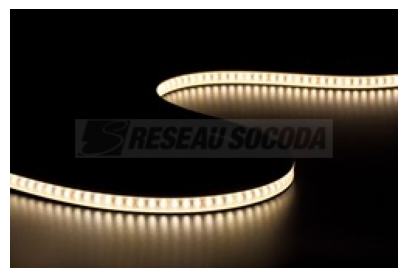

******************************************************


Predicted label: AMBIANCE	true label: PRODUCT


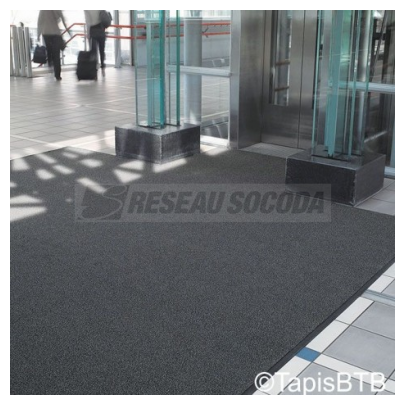

******************************************************




In [131]:
wrong = data.loc[preds!=y,:]
for i in wrong.index:
    print(f"Predicted label: {preds[i]}\ttrue label: {wrong.loc[i,'name']}")
    plt.figure(figsize=(5,5))
    plt.imshow(load_pic(wrong.loc[i,'path']))
    plt.axis("Off")
    plt.show()
    print("******************************************************\n\n")

In [118]:
X_test = []
files = os.listdir("test")
for f in files:
    pic = load_pic("test",f)
    row = get_stats(pic)
    row = row + get_stats(normalize_pic(pic))
    row = row + get_stats(pixelise_pic(pic))
    row = row + get_stats(pixelise_pic(conv(pic)))
    row = row + get_stats(pixelise_pic(crop(pic)))
    row = row + [pic.shape[0]*pic.shape[1]]
    X_test.append(row)
X_test = pd.DataFrame(X_test,columns=X.columns)
pred_test = classifier.predict(X_test)
test_probs = classifier.predict_proba(X_test)


In [129]:
for i in range(len(test_probs)):
    print(pred_test[i], test_probs[i],labels[np.argmax(test_probs[i])])

AMBIANCE [0.34280847 0.62640136 0.03079016] _PRODUCT
PRODUCT [0.00465882 0.99109247 0.00424872] _PRODUCT
AMBIANCE [0.55465319 0.41004114 0.03530567] _AMBIANCE
AMBIANCE [0.38579263 0.56072391 0.05348346] _PRODUCT
PRODUCT [0.09147457 0.88090766 0.02761777] _PRODUCT
PRODUCT [0.10225153 0.87866634 0.01908213] _PRODUCT
AMBIANCE [9.99624275e-01 1.47819284e-04 2.27905795e-04] _AMBIANCE
PRODUCT [0.02228464 0.95590315 0.02181221] _PRODUCT
PRODUCT [0.19531717 0.78471189 0.01997093] _PRODUCT
AMBIANCE [0.34549363 0.58074802 0.07375835] _PRODUCT
PRODUCT [0.17226768 0.77056608 0.05716624] _PRODUCT


Prediction: AMBIANCE


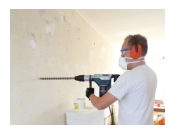

Prediction: PRODUCT


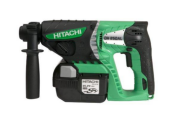

Prediction: AMBIANCE


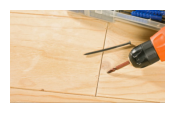

Prediction: AMBIANCE


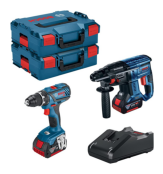

Prediction: PRODUCT


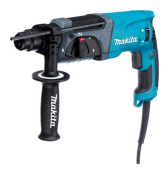

Prediction: PRODUCT


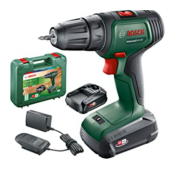

Prediction: AMBIANCE


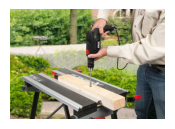

Prediction: PRODUCT


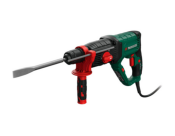

Prediction: PRODUCT


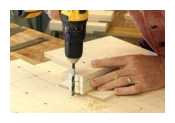

Prediction: AMBIANCE


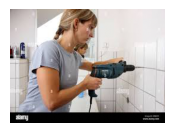

Prediction: PRODUCT


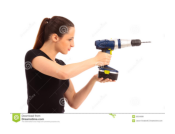

11 images in total


In [120]:
for i in range(len(files)):
    print(f"Prediction: {pred_test[i]}")
    pic = load_pic("test",files[i])
    plt.figure(figsize=(2,2))
    plt.imshow(pic)
    plt.axis("Off")
    plt.show()
print(len(files),"images in total")

### Tensorflow

In [121]:
import tensorflow as tf

In [173]:
tf_data = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1,height_shift_range=0.1,
                                                shear_range=0.1, zoom_range=0.1,horizontal_flip=True,vertical_flip=False,
                                                rescale=1/255.0)
tf_data = tf_data.flow_from_directory("./CARREFOUR/",
                                target_size=(224, 224),
                                class_mode='categorical')



Found 82 images belonging to 3 classes.


In [174]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(2,3,activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3,activation='softmax')
])
my_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [175]:
history = my_model.fit(tf_data,epochs=20)

Epoch 1/20
3/3 [==============================] - 1s 379ms/step - loss: 12.7062 - accuracy: 0.3902
Epoch 2/20
3/3 [==============================] - 1s 373ms/step - loss: 8.1718 - accuracy: 0.5732
Epoch 3/20
3/3 [==============================] - 1s 280ms/step - loss: 8.2460 - accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 1s 280ms/step - loss: 7.6607 - accuracy: 0.5244
Epoch 5/20
3/3 [==============================] - 1s 276ms/step - loss: 7.0312 - accuracy: 0.6829
Epoch 6/20
3/3 [==============================] - 1s 277ms/step - loss: 4.5998 - accuracy: 0.4512
Epoch 7/20
3/3 [==============================] - 1s 288ms/step - loss: 1.7487 - accuracy: 0.6829
Epoch 8/20
3/3 [==============================] - 1s 292ms/step - loss: 2.8313 - accuracy: 0.2805
Epoch 9/20
3/3 [==============================] - 1s 311ms/step - loss: 2.5438 - accuracy: 0.6707
Epoch 10/20
3/3 [==============================] - 1s 282ms/step - loss: 2.1389 - accuracy: 0.6707
Epoch 11/20
3/3 [=

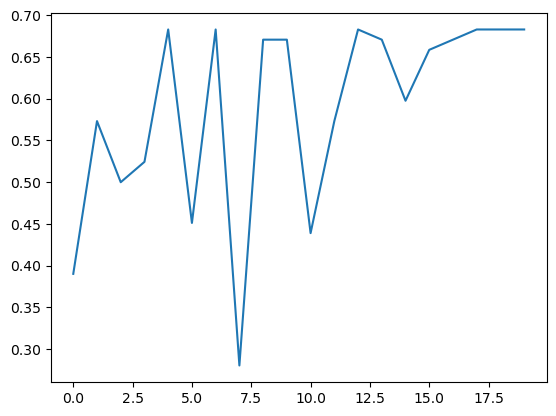

In [176]:
plt.plot(history.epoch,history.history['accuracy'])

In [40]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 197136)            0         
                                                                 
 dense (Dense)               (None, 3)                 591411    
                                                                 
Total params: 591,859
Trainable params: 591,859
Non-trainable params: 0
_________________________________________________________________


In [177]:
tf_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
tf_data = tf_data.flow_from_directory("./CARREFOUR/",
                                target_size=(224, 224),
                                class_mode='categorical')
my_model.evaluate(tf_data)

Found 82 images belonging to 3 classes.
3/3 [==============================] - 0s 118ms/step - loss: 0.6662 - accuracy: 0.7073


[0.666233241558075, 0.707317054271698]

In [185]:
[i for i in dir() if i[0]!="_"]

['Image',
 'In',
 'Out',
 'Pipeline',
 'SVC',
 'StandardScaler',
 'X',
 'X_test',
 'accuracy_score',
 'base',
 'classifier',
 'confusion_matrix',
 'conv',
 'conv_col',
 'crop',
 'crop_col',
 'data',
 'exit',
 'f',
 'files',
 'get_colors',
 'get_ipython',
 'get_q_colors',
 'get_stats',
 'history',
 'i',
 'labels',
 'load_pic',
 'mat',
 'my_model',
 'norm_col',
 'normalize_pic',
 'np',
 'os',
 'pd',
 'pic',
 'pix_col',
 'pixelise_pic',
 'plt',
 'pred_test',
 'preds',
 'probs',
 'quit',
 'random',
 'root_dir',
 'row',
 'sns',
 'std_col',
 'steps',
 'test',
 'test_probs',
 'tf',
 'tf_data',
 'visualise_colors',
 'visualize_sample',
 'wrong',
 'y']